In [1]:
import sys
# include the toolkit path in the modules paths
sys.path.append('../scripts')

# graphics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from IPython.html.widgets import interact

# maths
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit, minimize, leastsq

# the opsin-model toolkit
import marco_tools as mt

import quantities as pq

# plotting constants
FIG_BIG = (15,10)
FIG_H = (15,7)
FIG_SMALL = (7,7)

# help setting the text in a plot
def default_plot_setup(title='Title', xlabel='x',ylabel='y'):
    plt.title(title);
    plt.xlabel(xlabel)
    plt.ylabel(ylabel);

/home/marco/miniconda2/envs/condaPy2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/marco/miniconda2/envs/condaPy2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [6]:
# ExperimentFolder is an object that looks for experiment files in a given folder
folder = mt.ExperimentFolder("/home/marco/Desktop/_marco/ospin_model/opsin_model/experimental/CoChr_powerCurve/18012016/", file_extension='abf')
filenames = folder.file_names_as_string_list
filenames = sorted(map(lambda x : x.split('_')[1].split('.')[0], filenames))
filenames = map(lambda x : '20160118_' + x + '.abf', filenames )

print filenames
# ExperimentFile is an object that loads data from a CSV file




# efile = mt.ExperimentFile(folder.folder, filename)

IndexError: list index out of range

In [17]:
pulse_durations =np.array([100, 100, 50, 25, 25])*1.0 / 1000

exps = mt.ExperimentCollection()
for fn in filenames : 
    f = mt.ABFExperimentFile(folder.folder+fn)
    xdata, ydata = f.import_data(block=0, segment=0, signal=0)
    e = mt.OpsinExperiment(ydata, xdata=xdata)
    e.label = fn

    e.select_by_time(0.5,0.9)
    e.y.invert()
    e.update_raw_data_from_current()
    

    e.change_x_reference(0.5471)
    e.pulse_start = 0
    exps.append(e)
    
exps = exps[2:-3]
exps.pop(3)


# set pulse end
for i,e in enumerate(exps):
    e.pulse_end = pulse_durations[i]

In [18]:
plt.figure(figsize=FIG_H)
for e in exps:
    e.plot(label=e.label)

plt.legend(loc=4, prop={'size':18})

pulse_end = [0.7]

In [31]:
e = exps[-1]

plt.figure(figsize=FIG_H)
e.plot('.')
### OpsinFit is an object that helps fitting these parameters.
fit = mt.OpsinFit(e)
fit.fit_parameter("max_current", start_fit_time=0, end_fit_time=0.02)
fit_result = fit.model("max_current")
bnd = fit.fit_bnds("max_current")
norm_param = fit.max_current

# plt.plot(np.linspace(0,500,100),[norm_param]*100,'--',label="max current in a two level system = {}".format(int(round(norm_param))));
plt.plot(fit_result[0],fit_result[1],'k--',label="exponential fit of the highest power curve")
plt.plot(bnd[0],bnd[1],'ko')

# plt.legend();

In [47]:
plt.figure(figsize=(15,15))

plots = len(exps)
cols = 2
rows = plots/cols + plots%cols

pulse_end_times = []
tau_ons = []
tau_offs = []
sstate = []

for i,e in enumerate(exps):
  
    # fit tau_on and tau_off
    fit.e = e
#     fit.fit_parameter("max_current", start_fit_time=0, end_fit_time=0.0014)
    fit.fit_parameter("tau_on", start_fit_time=0,end_fit_time=0.01)
    fit.fit_parameter("tau_off", start_fit_time=pulse_durations[i] , end_fit_time=0.3, p0=[0.01,1000])
       
    pulse_end_times.append(e.pulse_end)

    
    tau_ons.append(fit.tau_on)
    tau_offs.append(fit.tau_off)

    # theoretical statdy state
    k_on = 1.0/fit.tau_on
    k_off = 1.0/fit.tau_off
    sst = k_on/(k_on+k_off)*norm_param
    sstate.append(sst)
    
    
    plt.subplot(rows,cols,i+1)
    # default_plot_setup(title= 'power= ' + str(round(e.light_power,3)),xlabel='',ylabel='')

    plt.plot(e.x, e.y, label=e.label )
    plt.plot(fit.model("tau_off")[0],fit.model("tau_off")[1],'r')
    plt.plot(fit.model("tau_on")[0],fit.model("tau_on")[1],'k', label="1-exp")
    plt.plot(fit.fit_bnds("tau_off")[0],fit.fit_bnds("tau_off")[1],'ro')
    plt.plot(fit.fit_bnds("tau_on")[0],fit.fit_bnds("tau_on")[1],'yo')
    #plt.plot(np.linspace(0,500,100),[sst]*100,'--g',label='2 levels steady state')

    plt.legend()

    #plt.axis([0,450,-20,norm_param+10])
    

    
plt.show()
# store the mean value of tau off
tau_off = np.mean(tau_offs)
#tau_on = np.mean(tau_ons)
print "media tau_off", np.mean(tau_offs)
print "media tau_on", np.mean(tau_ons)

media tau_off 0.0563408945525
media tau_on 0.0843879153226


(0, 0.12)

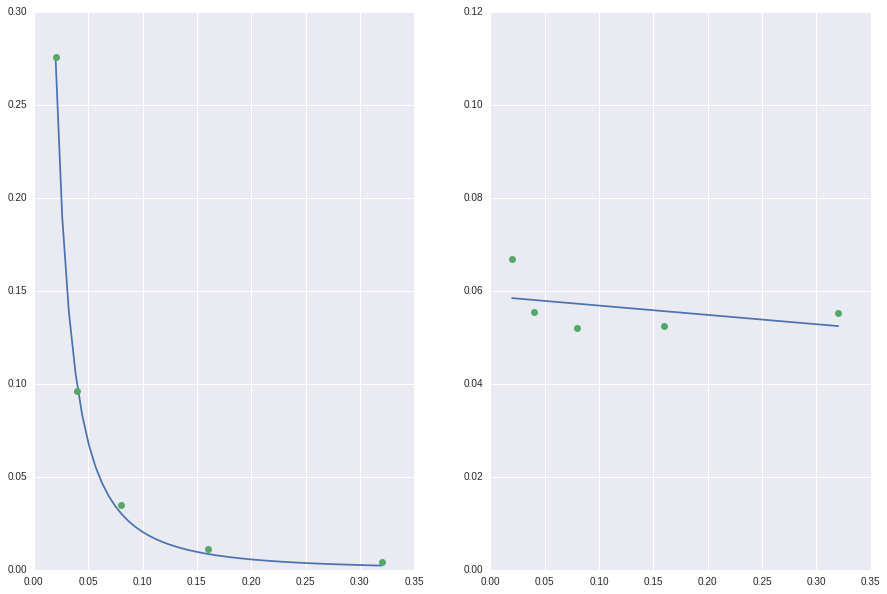

In [48]:
plt.figure(figsize=(15,10))

powervalues = np.array([0.02, 0.04, 0.08, 0.16, 0.32])
x=np.linspace(min(powervalues),max(powervalues))

def func_on(x,m,q):
    return m / ((x+q)**2)

# def func_on(x,m):
#     return m / (x**2)

def func_off(x,m,q):
    return m *x + q


popt_on, pcov_on = curve_fit(func_on,
                             powervalues,
                             np.array(tau_ons),
                             #p0=np.array([5.38288476e-02,   1.13175396e-04,   7.79980161e-01, 0]),
                            )

plt.subplot(1,2,1)
plt.plot(x, func_on(x, *popt_on),'-')
plt.plot(powervalues, tau_ons,'o',label='tau_on')


popt_off, pcov_off = curve_fit(func_off, powervalues, np.array(tau_offs))
plt.subplot(1,2,2)
plt.plot(x, func_off(x,popt_off[0],popt_off[1]),'-')
plt.plot(powervalues, tau_offs,'o',label='tau_off')
plt.ylim([0,0.12])

In [49]:
# lightpower = 1

# CONSTANTS DEFINING THE STATES
C = 0   # Closed state
O = 1   # Opens state
D = 2   # Desensitized state

# TRANSITION RATES
K_off = np.zeros([3,3]) # transition coefficient MATRIX when light is OFF
K_on =  np.zeros([3,3]) # transition coefficient MATRIX when light is ON

tau = tau_off #17.9 # usually called "tauoff" [ms] Exp Physiol. 2011 Jan; 96(1): 19–25. 
k = 1.0/tau

#beta = (k*0.7-k/3)/(powervalues[-1]-powervalues[0])# fit parameter
# beta = "ciao"

K_off[O,C] = k
K_on[O,C] = k # this transition does not depend on light

#K_off[C,O] = 0
#K_on[C,O] = k

#K_off[O,D] = 0
#K_on[O,D] = lightpower*beta

#K_off[D,O] = k/30
#K_on[D,O] = K_off[D,O] # k/30

In [50]:
def func_kd(t,kod,kdc):
#     K_on[O,D] = kod
#     K_off[O,D] = kod
#     K_on[D,C] = kdc
#     K_off[D,C] = kdc
    v = odeint(mt.ode_model_generic, initial_condition, t, (K_off,K_on,pulse), hmax=10)
    return v[:,1]

In [51]:
### THE WORKING FUNCTION
# names = ['Kod','Kdo']
# def func_kd(t,kod,kdo):
#     K_on[O,D] = kod
#     K_off[O,D] = kod
#     K_on[D,O] = kdo
    
#     v = odeint(mt.ode_model_generic, initial_condition, t, (K_off,K_on,pulse), hmax=10)
#     return v[:,1]

### BENOIT's TEST
names = ['Kod','Kdc']
def func_kd(t,kod,kdc):
    K_on[O,D] = kod
    K_off[O,D] = kod
    K_on[D,C] = kdc
    K_off[D,C] = kdc
    v = odeint(mt.ode_model_generic, initial_condition, t, (K_off,K_on,pulse), hmax=10)
    return v[:,1]


popt_kd = np.zeros((len(exps),2))
initial_condition = [norm_param,0,0]

print "WARGING : if measurement errors are not specified,\
confidence intervals do not make much sense\n"
# print "68% CONFIDENCE INTERVALS:"

for i,e in enumerate(exps) :
    
    lightpower = powervalues[i]
    this_tau_on = func_on(lightpower,*popt_on)
    K_on[C,O] = 1.0/this_tau_on
    pulse_duration = e.pulse_end-e.pulse_start
    pulse = mt.Pulse(e.pulse_start,pulse_duration,10000)
    
    popt_kd[i], pcov_kd = curve_fit(func_kd, e.x, e.y, p0=(0.005,0.005))
    

    print "curve %x" % i
    for j,p in enumerate(popt_kd[i]):
        print "{} : {:.2E} +/- {:.2E}".format(names[j], p, np.sqrt(pcov_kd[j,j]))
    print ""


for i in range(popt_kd.shape[1]):
    k_temp = np.mean(popt_kd[:,i])
    print "mean {} : {:.2E},\t tau = {:.2E} ms".format(names[i], k_temp, 1.0/k_temp)

WARGING : if measurement errors are not specified,confidence intervals do not make much sense

curve 0
Kod : 5.51E-03 +/- 4.47E-05
Kdc : 2.26E-02 +/- 6.19E-05

curve 1
Kod : 5.00E-03 +/- 2.28E-05
Kdc : 5.00E-03 +/- 2.81E-04

curve 2
Kod : 7.09E-03 +/- 5.21E-05
Kdc : 5.19E-03 +/- 3.01E-03

curve 3
Kod : 5.00E-03 +/- 1.86E-05
Kdc : 5.00E-03 +/- 7.17E-04

curve 4
Kod : 4.64E-03 +/- 2.58E-05
Kdc : 1.03E-02 +/- 5.23E-05

mean Kod : 5.45E-03,	 tau = 1.84E+02 ms
mean Kdc : 9.63E-03,	 tau = 1.04E+02 ms


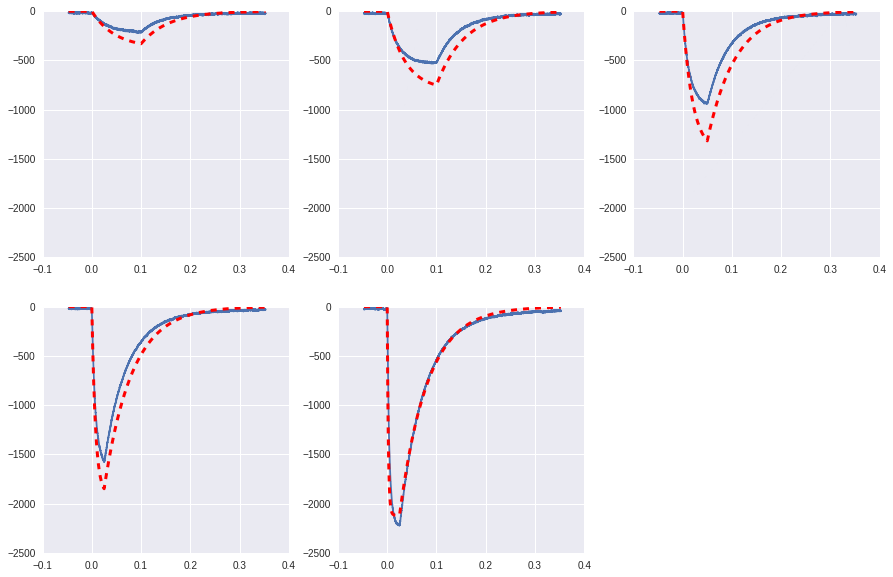

In [52]:
plt.figure(figsize=(15,15))

INVERT = -1

for i,e in enumerate(exps) :
    ax = plt.subplot(3,3,i+1)
    
    lightpower = powervalues[i]
    this_tau_on = func_on(lightpower,*popt_on)
    
    K_on[C,O] = 1.0/this_tau_on

    
    pulse_duration = e.pulse_end-e.pulse_start
    pulse = mt.Pulse(e.pulse_start,pulse_duration,10000)
    
#     plt.plot(e.x,e.y)
#     plt.plot(e.x, func_kd(e.x,popt_kd[i]),'--r',lw=2)
    
    plt.plot(e.x,INVERT*e.y,label=e.label);
    plt.plot(e.x,INVERT*func_kd(e.x,*popt_kd[i]),'r--',linewidth='3',label='fit');

    
    plt.axis([-0.1,0.4,-2500,0])
    